In [1]:
import numba
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
import IPython
import IPython.display

2023-02-15 17:50:38.228484: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-15 17:50:40.345364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-02-15 17:50:40.348321: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda-11.7/lib64:
2023-02-15 17:50:40.348339: W tensorflow/compiler/tf2tensorrt/utils/py_utils.c

## Récupération des données

In [2]:
columns = ["Date", "Heure", "SG Hauteur", "SG Ectype", "SG Q", "SN Hauteur", "SN Ectype", "SN Q",
          "Montoir Hauteur", "Montoir Ectype", "Montoir Q", "Paimboeuf Hauteur", "Paimboeuf Ectype", "Paimboeuf Q",
          "Cordemais Hauteur", "Cordemais Ectype", "Cordemais Q", "LP Hauteur", "LP Ectype", "LP Q",
          "NUB Hauteur", "NUB Ectype", "NUB Q", "NSAL Hauteur", "NSAL Ectype", "NSAL Q", "SG Patm", "Nantes Patm"]

chunks = pd.read_csv("Datas/X_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
X = pd.DataFrame()
for chunk in chunks:
    X = pd.concat((X,chunk))

print(X)
X.pop('Date')

                       Date  SN Hauteur (t-24)  SN Hauteur (t-23)  \
24      2012-01-01 02:00:00               3.96               3.94   
25      2012-01-01 02:05:00               3.94               3.93   
26      2012-01-01 02:10:00               3.93               3.91   
27      2012-01-01 02:15:00               3.91               3.89   
28      2012-01-01 02:20:00               3.89               3.87   
...                     ...                ...                ...   
217994  2014-01-27 01:40:00               4.77               4.82   
217995  2014-01-27 01:45:00               4.82               4.84   
217996  2014-01-27 01:50:00               4.84               4.87   
217997  2014-01-27 01:55:00               4.87               4.88   
217998  2014-01-27 02:00:00               4.88               4.89   

        SN Hauteur (t-22)  SN Hauteur (t-21)  SN Hauteur (t-20)  \
24                   3.93               3.91               3.89   
25                   3.91            

24        2012-01-01 02:00:00
25        2012-01-01 02:05:00
26        2012-01-01 02:10:00
27        2012-01-01 02:15:00
28        2012-01-01 02:20:00
                 ...         
217994    2014-01-27 01:40:00
217995    2014-01-27 01:45:00
217996    2014-01-27 01:50:00
217997    2014-01-27 01:55:00
217998    2014-01-27 02:00:00
Name: Date, Length: 198007, dtype: object

In [3]:
chunks = pd.read_csv("Datas/Y_tides.csv", index_col=0, chunksize = 1e6, iterator = True, low_memory = False)
Y = pd.DataFrame()
for chunk in chunks:
    Y = pd.concat((Y,chunk))

print(Y)
Y.pop('Date')

                       Date  SN Hauteur (t)  SN Hauteur (t+1)  \
24      2012-01-01 02:00:00            3.12              3.07   
25      2012-01-01 02:05:00            3.07              3.01   
26      2012-01-01 02:10:00            3.01              2.95   
27      2012-01-01 02:15:00            2.95              2.89   
28      2012-01-01 02:20:00            2.89              2.83   
...                     ...             ...               ...   
217994  2014-01-27 01:40:00            5.09              5.08   
217995  2014-01-27 01:45:00            5.08              5.07   
217996  2014-01-27 01:50:00            5.07              5.06   
217997  2014-01-27 01:55:00            5.06              5.06   
217998  2014-01-27 02:00:00            5.06              5.07   

        SN Hauteur (t+2)  Montoir Hauteur (t)  Montoir Hauteur (t+1)  \
24                  3.01                 3.37                   3.32   
25                  2.95                 3.32                   3.27   
26 

24        2012-01-01 02:00:00
25        2012-01-01 02:05:00
26        2012-01-01 02:10:00
27        2012-01-01 02:15:00
28        2012-01-01 02:20:00
                 ...         
217994    2014-01-27 01:40:00
217995    2014-01-27 01:45:00
217996    2014-01-27 01:50:00
217997    2014-01-27 01:55:00
217998    2014-01-27 02:00:00
Name: Date, Length: 198007, dtype: object

### Longueur d'entrée et de sortie

In [4]:
# Ces longueurs sont définies par les fichiers .csv
input_length = 24
output_length = 3

### Réorganisation des données

In [5]:
# Input features
Nb_features = int(X.shape[1]/input_length)
print(f"Number of features : {Nb_features}")

Nb_labels = int(Y.shape[1]/output_length)
print(f"Number of Label : {Nb_labels}")

Number of features : 9
Number of Label : 7


In [6]:
print(X.head)
print(Y.head)

X_datas = X.values
X_datas = X_datas.reshape((X.shape[0], input_length, Nb_features), order = 'F')
Y_datas = Y.values
Y_datas = Y_datas.reshape((Y.shape[0], output_length, Nb_labels), order ='F')

<bound method NDFrame.head of         SN Hauteur (t-24)  SN Hauteur (t-23)  SN Hauteur (t-22)  \
24                   3.96               3.94               3.93   
25                   3.94               3.93               3.91   
26                   3.93               3.91               3.89   
27                   3.91               3.89               3.87   
28                   3.89               3.87               3.85   
...                   ...                ...                ...   
217994               4.77               4.82               4.84   
217995               4.82               4.84               4.87   
217996               4.84               4.87               4.88   
217997               4.87               4.88               4.89   
217998               4.88               4.89               4.92   

        SN Hauteur (t-21)  SN Hauteur (t-20)  SN Hauteur (t-19)  \
24                   3.91               3.89               3.87   
25                   3.89      

In [7]:
n = len(X_datas)
# Train dataset
X_train = X_datas[:int(0.7*n)]
Y_train = Y_datas[:int(0.7*n)]

# Validation dataset
X_val = X_datas[int(0.7*n):int(0.9*n)]
Y_val = Y_datas[int(0.7*n):int(0.9*n)]

# Test dataset
X_test = X_datas[int(0.9*n):]
Y_test = Y_datas[int(0.9*n):]

X_train

array([[[   3.96,    4.08,    4.09, ...,    4.68, 1017.9 , 1018.8 ],
        [   3.94,    4.07,    4.07, ...,    4.64, 1017.4 , 1018.2 ],
        [   3.93,    4.05,    4.06, ...,    4.61, 1018.1 , 1018.4 ],
        ...,
        [   3.27,    3.5 ,    3.63, ...,    4.17, 1017.2 , 1017.7 ],
        [   3.23,    3.47,    3.59, ...,    4.16, 1016.7 , 1018.  ],
        [   3.18,    3.42,    3.54, ...,    4.15, 1016.8 , 1017.7 ]],

       [[   3.94,    4.07,    4.07, ...,    4.64, 1017.4 , 1018.2 ],
        [   3.93,    4.05,    4.06, ...,    4.61, 1018.1 , 1018.4 ],
        [   3.91,    4.03,    4.03, ...,    4.57, 1017.4 , 1019.  ],
        ...,
        [   3.23,    3.47,    3.59, ...,    4.16, 1016.7 , 1018.  ],
        [   3.18,    3.42,    3.54, ...,    4.15, 1016.8 , 1017.7 ],
        [   3.12,    3.37,    3.48, ...,    4.14, 1017.  , 1017.5 ]],

       [[   3.93,    4.05,    4.06, ...,    4.61, 1018.1 , 1018.4 ],
        [   3.91,    4.03,    4.03, ...,    4.57, 1017.4 , 1019.  ],
    

In [8]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                             X: 327.8 MiB
                         chunk: 47.6 MiB
                             Y: 33.2 MiB
                            __: 15.9 MiB
                           ___: 15.9 MiB
                            _2: 15.9 MiB
                            _3: 15.9 MiB
                           _i2:  681.0 B
                           _i8:  587.0 B
                            _i:  328.0 B


### Création du modèle

In [10]:
multi_conv_model = tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(32, activation='relu', kernel_size=(3), input_shape = (input_length, Nb_features)),
    tf.keras.layers.Flatten(),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_conv_model.summary()

2023-02-15 16:46:14.944526: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 16:46:15.057822: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 16:46:15.058130: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 16:46:15.060030: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 10, 32)            800       
                                                                 
 flatten (Flatten)           (None, 320)               0         
                                                                 
 dense (Dense)               (None, 18)                5778      
                                                                 
 reshape (Reshape)           (None, 3, 6)              0         
                                                                 
Total params: 6,578
Trainable params: 6,578
Non-trainable params: 0
_________________________________________________________________


In [9]:
multi_lstm_model =  tf.keras.Sequential([
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.LSTM(256, activation='tanh', input_shape = (input_length, Nb_features)),
    #tf.keras.layers.Dropout(0.2),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(output_length*Nb_labels, kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([output_length, Nb_labels])
])
multi_lstm_model.summary()

2023-02-15 17:51:25.946404: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 17:51:26.057108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 17:51:26.057424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-15 17:51:26.058843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 256)               272384    
                                                                 
 dense (Dense)               (None, 21)                5397      
                                                                 
 reshape (Reshape)           (None, 3, 7)              0         
                                                                 
Total params: 277,781
Trainable params: 277,781
Non-trainable params: 0
_________________________________________________________________


### Compilation

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=2,
                                                mode='min')


multi_lstm_model.compile(loss=tf.losses.MeanSquaredError(),
            optimizer=tf.optimizers.Adam(),
            metrics=[tf.metrics.MeanAbsoluteError()])


### Entrainement

In [11]:
MAX_EPOCHS = 10
history = multi_lstm_model.fit(X_train, Y_train, epochs=MAX_EPOCHS, callbacks=[early_stopping], batch_size = 1024, validation_data=(X_val, Y_val))

2023-02-15 17:51:35.494216: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 119753856 exceeds 10% of free system memory.
2023-02-15 17:51:35.945905: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 119753856 exceeds 10% of free system memory.


Epoch 1/10


2023-02-15 17:51:43.495355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8700
2023-02-15 17:51:45.084022: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f399806eda0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-02-15 17:51:45.084105: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2023-02-15 17:51:45.503226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-02-15 17:51:47.091620: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


136/136 [==============================] - 18s 54ms/step - loss: 5.5324 - mean_absolute_error: 1.7028 - val_loss: 3.8687 - val_mean_absolute_error: 1.2820
Epoch 2/10
136/136 [==============================] - 6s 42ms/step - loss: 2.8864 - mean_absolute_error: 1.1556 - val_loss: 3.6217 - val_mean_absolute_error: 1.1997
Epoch 3/10
136/136 [==============================] - 6s 41ms/step - loss: 2.6971 - mean_absolute_error: 1.0857 - val_loss: 3.4522 - val_mean_absolute_error: 1.1367
Epoch 4/10
136/136 [==============================] - 6s 41ms/step - loss: 2.5571 - mean_absolute_error: 1.0300 - val_loss: 3.3183 - val_mean_absolute_error: 1.0844
Epoch 5/10
136/136 [==============================] - 6s 42ms/step - loss: 2.4388 - mean_absolute_error: 0.9811 - val_loss: 3.1976 - val_mean_absolute_error: 1.0347
Epoch 6/10
136/136 [==============================] - 6s 42ms/step - loss: 2.3354 - mean_absolute_error: 0.9371 - val_loss: 3.0943 - val_mean_absolute_error: 0.9904
Epoch 7/10
136/136 [

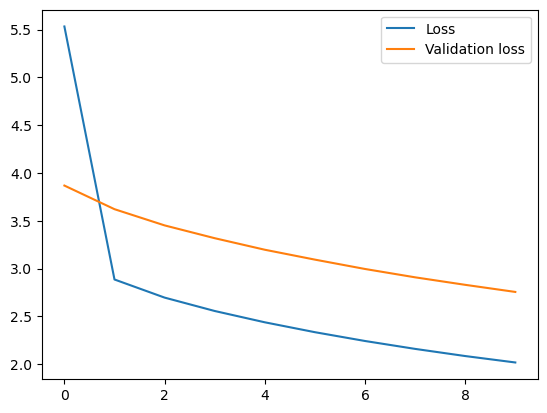

In [12]:
plt.plot(history.history["loss"], label = "Loss")
plt.plot(history.history["val_loss"], label = "Validation loss")

plt.legend()
plt.show()

In [68]:
multi_lstm_model.save("models/MultiLSTM", save_format="h5")

In [13]:
multi_lstm_model.evaluate(X_test, Y_test)

619/619 [==============================] - 4s 7ms/step - loss: 16.6282 - mean_absolute_error: 0.9293


[16.628173828125, 0.9293013215065002]

In [14]:
test = np.array([X_train[0]])
real = np.array([Y_train[0]])
test

array([[[   3.96,    4.08,    4.09,    4.06,    4.26,    4.53,    4.68,
         1017.9 , 1018.8 ],
        [   3.94,    4.07,    4.07,    4.06,    4.23,    4.5 ,    4.64,
         1017.4 , 1018.2 ],
        [   3.93,    4.05,    4.06,    4.05,    4.22,    4.47,    4.61,
         1018.1 , 1018.4 ],
        [   3.91,    4.03,    4.03,    4.04,    4.19,    4.44,    4.57,
         1017.4 , 1019.  ],
        [   3.89,    4.02,    4.02,    4.02,    4.18,    4.4 ,    4.54,
         1017.6 , 1019.3 ],
        [   3.87,    4.  ,    4.01,    4.01,    4.16,    4.38,    4.51,
         1017.9 , 1018.9 ],
        [   3.85,    3.98,    3.99,    3.99,    4.15,    4.35,    4.48,
         1017.6 , 1018.9 ],
        [   3.82,    3.98,    3.98,    3.97,    4.14,    4.33,    4.45,
         1017.9 , 1018.6 ],
        [   3.79,    3.96,    3.96,    3.96,    4.13,    4.31,    4.43,
         1018.2 , 1018.1 ],
        [   3.76,    3.93,    3.96,    3.94,    4.12,    4.29,    4.4 ,
         1017.5 , 1018.2 ],


In [15]:
pred = multi_lstm_model.predict(test)

1/1 [==============================] - 0s 361ms/step


In [16]:
pred

array([[[3.2368422, 3.3541212, 3.3897681, 3.4670799, 3.7844198,
         3.9744391, 4.1422577],
        [3.234897 , 3.3549838, 3.398082 , 3.4696567, 3.7899475,
         3.9732707, 4.13517  ],
        [3.234755 , 3.355762 , 3.3891673, 3.4593918, 3.7865994,
         3.9723492, 4.1159716]]], dtype=float32)

TypeError: subplot() takes 1 or 3 positional arguments but 2 were given

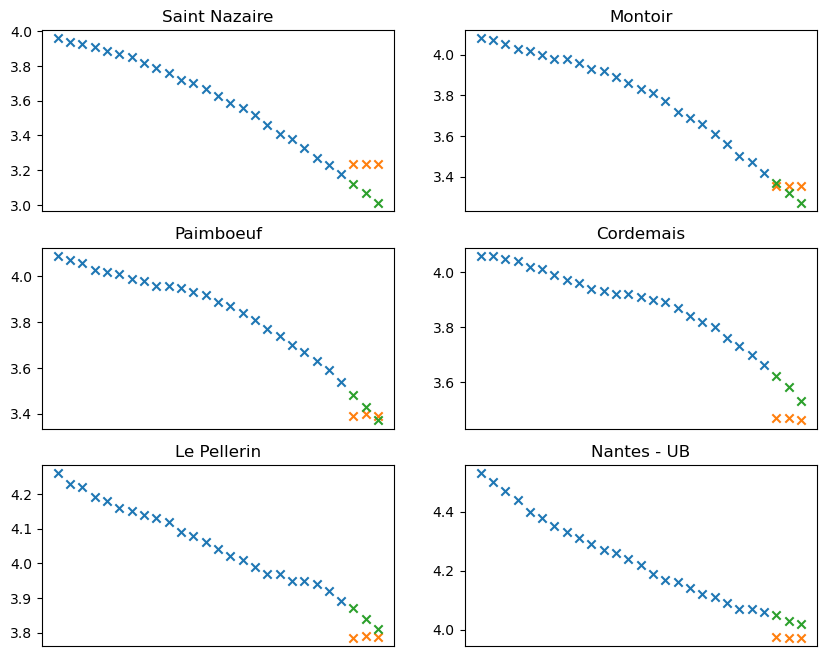

In [20]:
ports =["Saint Nazaire", "Montoir", "Paimboeuf", "Cordemais", "Le Pellerin", "Nantes - UB"]
abs = [i for i in range(input_length+output_length)]
fig, axs = plt.subplots(3,2, figsize = (10,8))
axs = axs.reshape([axs.shape[0]*axs.shape[1]])
for ax,i in zip(axs,range(pred.shape[2]-1)):
    ax.set_title(ports[i])
    ax.get_xaxis().set_visible(False)
    ax.scatter(abs[:input_length], test[0,:,i], label = "Previous steps", marker="x")
    ax.scatter(abs[input_length:], pred[0,:,i], label = "Predicted steps", marker="x")
    ax.scatter(abs[input_length:], real[0,:,i], label = "Real steps", marker="x")

handles, labels = ax.get_legend_handles_labels()

ax = fig.add_subplot(2,2)
ax.scatter(abs[:input_length], test[0,:,-1])


fig.legend(handles, labels, loc='upper center')
plt.show()
fig.savefig("Predictions.png")